In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Configurar dispositivo para GPU si está disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Usando el dispositivo: {device}')

Usando el dispositivo: cuda:0


In [3]:
# Cargar el modelo y el tokenizador pre-entrenado
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=7)  # 7 clases
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

In [4]:
# Mover el modelo a la GPU si está disponible
model.to(device='cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

PREPARACION DE LOS DATOS

In [5]:
# seleccionamos el arhchivo datos_editados_18.95.csv

from google.colab import files

# Cargar el archivo desde el sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Listar los archivos en el directorio actual
!ls

# Obtener la ruta del archivo en el sistema de archivos de Colab
import os
current_directory = os.getcwd()
file_path = os.path.join(current_directory, file_name)
print("Ruta del archivo:", file_path)

Saving datos_editados_18_05_versioninicial.csv to datos_editados_18_05_versioninicial.csv
datos_editados_18_05_versioninicial.csv  sample_data
Ruta del archivo: /content/datos_editados_18_05_versioninicial.csv


In [6]:
datos_editados = pd.read_csv("datos_editados_18_05_versioninicial.csv",encoding='latin1') # estos datos los hemos extraido de manera previa uniendo la variable "4"="CAOS" para ver si tenían mas relacion

In [7]:
print(len(datos_editados)) #1013

1013


In [8]:
# En los datos de entrenamiento tendría que haber informacion suficiente para entrenar de todas las variables ( a destacar la variable 4 (CAOS))
train_texts, test_texts, train_labels, test_labels = train_test_split(datos_editados['Frase'], datos_editados['Consensuada'], test_size=0.2, random_state=42,stratify=datos_editados['Consensuada'] )


In [9]:
y = datos_editados.Consensuada

In [10]:
# RECUENTO POR CADA CLASE de la variable "Consensuada"
unique, counts = np.unique(y, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TOTAL %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TOTAL 0: Samples 209
Consensuada TOTAL 1: Samples 186
Consensuada TOTAL 2: Samples 276
Consensuada TOTAL 3: Samples 184
Consensuada TOTAL 4: Samples 92
Consensuada TOTAL 5: Samples 41
Consensuada TOTAL 6: Samples 25


In [11]:
# RECUENTO EN LOS DATOS DE ENTRENAMIENTO
unique, counts = np.unique(train_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TRAIN %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TRAIN 0: Samples 167
Consensuada TRAIN 1: Samples 149
Consensuada TRAIN 2: Samples 221
Consensuada TRAIN 3: Samples 147
Consensuada TRAIN 4: Samples 73
Consensuada TRAIN 5: Samples 33
Consensuada TRAIN 6: Samples 20


In [12]:
# Veamos ahora el recuento en los DATOS DE TEST
# Number of samples per class
unique, counts = np.unique(test_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TEST %i: Samples %i' % (unique[i], counts[i]) )
# efectivamente está mal porque

Consensuada TEST 0: Samples 42
Consensuada TEST 1: Samples 37
Consensuada TEST 2: Samples 55
Consensuada TEST 3: Samples 37
Consensuada TEST 4: Samples 19
Consensuada TEST 5: Samples 8
Consensuada TEST 6: Samples 5


In [13]:
!pip install transformers

In [14]:
# Tokenización y creación de datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True,max_length=64)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True,max_length=64)

In [15]:
train_labels = torch.tensor(train_labels.tolist()).to(device='cuda:0')
test_labels = torch.tensor(test_labels.tolist()).to(device='cuda:0')

## Convertimos ahora los datos a tensores de PyTorch

In [16]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(train_encodings['attention_mask']).to(device='cuda:0'),
    train_labels
)

In [17]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(test_encodings['attention_mask']).to(device='cuda:0'),
    test_labels
)

## Definimos el DataLoader para cargar los datos durante el entrenamiento

In [18]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Optimizador y funcion de perdida

In [19]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer = AdamW(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()




```
# max_length = 512
# lr = 2e-5
# stratify=datos_editados['Consensuada']
```



In [20]:
model.train()
for epoch in range(30):  # Cambia el número de épocas según necesites
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    accuracy = correct_predictions / total_predictions

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}, Loss: {total_loss}, Accuracy: {accuracy}")



Epoch 1, Loss: 38.484063267707825, Accuracy: 0.4382716049382716
Epoch 2, Loss: 28.809369385242462, Accuracy: 0.5975308641975309
Epoch 3, Loss: 22.43499493598938, Accuracy: 0.6888888888888889
Epoch 4, Loss: 14.538878560066223, Accuracy: 0.837037037037037
Epoch 5, Loss: 8.617173731327057, Accuracy: 0.9037037037037037
Epoch 6, Loss: 5.87496667355299, Accuracy: 0.9358024691358025
Epoch 7, Loss: 4.016249548643827, Accuracy: 0.9604938271604938
Epoch 8, Loss: 3.4065525121986866, Accuracy: 0.9654320987654321
Epoch 9, Loss: 2.127836462110281, Accuracy: 0.9765432098765432
Epoch 10, Loss: 2.2327620275318623, Accuracy: 0.9703703703703703
Epoch 11, Loss: 2.296256946399808, Accuracy: 0.9654320987654321
Epoch 12, Loss: 2.0475873555988073, Accuracy: 0.9765432098765432
Epoch 13, Loss: 1.9275127416476607, Accuracy: 0.9753086419753086
Epoch 14, Loss: 2.1436334382742643, Accuracy: 0.9691358024691358
Epoch 15, Loss: 1.5116796251386404, Accuracy: 0.9765432098765432
Epoch 16, Loss: 1.5305260731838644, Accura

## evaluacion del conjunto de pruebas

In [21]:
# Evaluación del modelo
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [22]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
class_names = ['NHE', 'AA', 'E', 'CON','CA','HEA','D']


In [24]:
# Impresión de métricas de evaluación
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.59      0.73      0.65        37
           2       0.98      0.82      0.89        55
           3       0.47      0.51      0.49        37
           4       0.60      0.63      0.62        19
           5       0.25      0.12      0.17         8
           6       0.25      0.20      0.22         5

    accuracy                           0.66       203
   macro avg       0.54      0.53      0.53       203
weighted avg       0.67      0.66      0.66       203



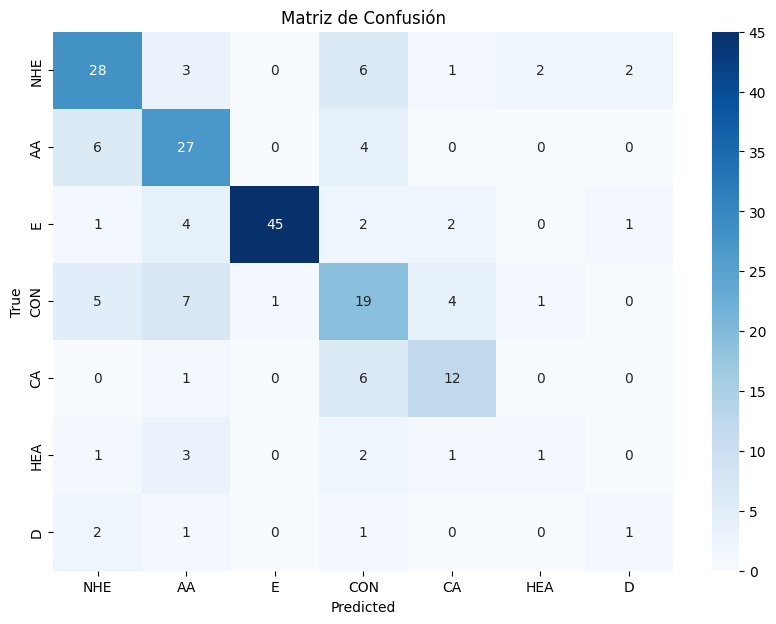

In [25]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()